# Machine Learning for Marketing

In [1]:
from seaborn import load_dataset
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.precision = 4 # this option limits the number of digits displayed
pd.options.mode.chained_assignment = None # prevents an error warning when slicing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix   #chat gpt said this was for an older version
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from plot_metric.functions import BinaryClassification # pip install plot-metric
import scikitplot as skplt # conda install -c conda-forge scikit-plot
from mlxtend.plotting import plot_confusion_matrix # pip install mlxtend


In [3]:
columns = ['alive', 'class', 'embarked', 'who', 'alone', 'adult_male']
df = load_dataset('titanic').drop(columns=columns)
df['deck'] = df['deck'].astype('object')
print(df.shape)
df.head()

(891, 9)


,survived,pclass,sex,age,sibsp,parch,fare,deck,embark_town
0,0,3,male,22.0,1,0,7.2500,NaN,Southampton
1,1,1,female,38.0,1,0,71.2833,C,Cherbourg
2,1,3,female,26.0,0,0,7.9250,NaN,Southampton
3,1,1,female,35.0,1,0,53.1000,C,Southampton
4,0,3,male,35.0,0,0,8.0500,NaN,Southampton


In [4]:
SEED = 42
TARGET = 'survived'
FEATURES = df.columns.drop(TARGET)

NUMERICAL = df[FEATURES].select_dtypes('number').columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: pclass, age, sibsp, parch, fare
Categorical features: deck, embark_town, sex


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=TARGET), df[TARGET], 
                                                    test_size=.2, random_state=SEED, 
                                                    stratify=df[TARGET])
num_imputer = SimpleImputer(strategy='mean')
train_num_imputed = num_imputer.fit_transform(X_train[NUMERICAL])

scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(train_num_imputed)

cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train_cat_imputed = cat_imputer.fit_transform(X_train[CATEGORICAL])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
train_cat_encoded = encoder.fit_transform(train_cat_imputed)

train_preprocessed = np.concatenate((train_num_scaled, train_cat_encoded), axis=1)

columns = np.append(NUMERICAL, encoder.get_feature_names_out(CATEGORICAL))
pd.DataFrame(train_preprocessed, columns=columns, index=X_train.index).head()

/Users/kaylaburge/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,pclass,age,sibsp,parch,fare,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_missing,embark_town_Queenstown,embark_town_Southampton,embark_town_missing,sex_male
692,1.0,0.3693,0.000,0.0000,0.1103,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
481,0.5,0.3693,0.000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
527,0.0,0.3693,0.000,0.0000,0.4329,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
855,1.0,0.2209,0.000,0.1667,0.0182,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
801,0.5,0.3843,0.125,0.1667,0.0512,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [6]:
model = LogisticRegression()
model.fit(train_preprocessed, y_train)

LogisticRegression()

In [7]:
def calculate_roc_auc(model_pipe, X, y):
    """Calculate roc auc score. 
    
    Parameters:
    ===========
    model_pipe: sklearn model or pipeline
    X: features
    y: true target
    """
    y_proba = model_pipe.predict_proba(X)[:,1]
    return roc_auc_score(y, y_proba)

In [8]:
test_num_imputed = num_imputer.transform(X_test[NUMERICAL])
test_num_scaled = scaler.transform(test_num_imputed)
test_cat_imputed = cat_imputer.transform(X_test[CATEGORICAL])
test_cat_encoded = encoder.transform(test_cat_imputed)
test_preprocessed = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)

print(f"Train ROC-AUC: {calculate_roc_auc(model, train_preprocessed, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(model, test_preprocessed, y_test):.4f}")

Train ROC-AUC: 0.8670
Test ROC-AUC: 0.8332


### The pipeline approach.

In [9]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, NUMERICAL),
    ('cat', categorical_pipe, CATEGORICAL)
])

pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression())
])

pipe.fit(X_train, y_train)

/Users/kaylaburge/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['deck', 'embark_town', 'sex'], dtype='object'))])),
                ('model', LogisticRegression())])

In [10]:
print(f"Train ROC-AUC: {calculate_roc_auc(pipe, X_train, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(pipe, X_test, y_test):.4f}")

Train ROC-AUC: 0.8670
Test ROC-AUC: 0.8332


## Illustrate Machine Learning Metrics

In [11]:
test_LG1 = pd.DataFrame(test_preprocessed, columns=columns, index=X_test.index)
test_LG1.head()

,pclass,age,sibsp,parch,fare,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_missing,embark_town_Queenstown,embark_town_Southampton,embark_town_missing,sex_male
565,1.0,0.2963,0.250,0.0000,0.0471,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
160,1.0,0.5476,0.000,0.1667,0.0314,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
553,1.0,0.2712,0.000,0.0000,0.0141,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
860,1.0,0.5099,0.250,0.0000,0.0275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
241,1.0,0.3693,0.125,0.0000,0.0303,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [12]:
probs = pipe.predict_proba(X_test)
probs = probs[:, 1]
probs

array([0.08316574, 0.06057985, 0.1645735 , 0.05458905, 0.68033316,
       0.48324066, 0.68592333, 0.32373858, 0.40068986, 0.14095838,
       0.16087316, 0.10004733, 0.57080473, 0.21461175, 0.4270629 ,
       0.17852022, 0.4467191 , 0.08996905, 0.12122638, 0.69704659,
       0.08996905, 0.70944115, 0.08955937, 0.47436331, 0.09169584,
       0.94580922, 0.44116399, 0.2997102 , 0.14105861, 0.13918806,
       0.08141193, 0.91391262, 0.11805572, 0.31567997, 0.12406603,
       0.13846063, 0.13134823, 0.46232435, 0.16087316, 0.75442066,
       0.17645439, 0.94440885, 0.1132677 , 0.78149393, 0.69294982,
       0.11061425, 0.0900692 , 0.45560877, 0.75960674, 0.8319533 ,
       0.89593227, 0.55281174, 0.70561956, 0.17030397, 0.58178733,
       0.0984348 , 0.08070832, 0.62054787, 0.60857752, 0.27788284,
       0.64071394, 0.64979691, 0.12409097, 0.11976228, 0.3842628 ,
       0.56886147, 0.88975954, 0.08347661, 0.42294619, 0.19277869,
       0.88856435, 0.13845892, 0.67835142, 0.93060701, 0.15878

In [13]:
test_LG1['probsLG1'] = probs
test_LG1.head()

,pclass,age,sibsp,parch,fare,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_missing,embark_town_Queenstown,embark_town_Southampton,embark_town_missing,sex_male,probsLG1
565,1.0,0.2963,0.250,0.0000,0.0471,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0832
160,1.0,0.5476,0.000,0.1667,0.0314,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0606
553,1.0,0.2712,0.000,0.0000,0.0141,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.1646
860,1.0,0.5099,0.250,0.0000,0.0275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0546
241,1.0,0.3693,0.125,0.0000,0.0303,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.6803


In [14]:
test_LG1['Outcome'] = y_test
test_LG1.head()

,pclass,age,sibsp,parch,fare,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_missing,embark_town_Queenstown,embark_town_Southampton,embark_town_missing,sex_male,probsLG1,Outcome
565,1.0,0.2963,0.250,0.0000,0.0471,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0832,0
160,1.0,0.5476,0.000,0.1667,0.0314,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0606,0
553,1.0,0.2712,0.000,0.0000,0.0141,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.1646,1
860,1.0,0.5099,0.250,0.0000,0.0275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0546,0
241,1.0,0.3693,0.125,0.0000,0.0303,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.6803,1


In [15]:
predictions = pipe.predict(X_test)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0])

In [16]:
test_LG1['Predictions'] = predictions
test_LG1.head()

,pclass,age,sibsp,parch,fare,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_missing,embark_town_Queenstown,embark_town_Southampton,embark_town_missing,sex_male,probsLG1,Outcome,Predictions
565,1.0,0.2963,0.250,0.0000,0.0471,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0832,0,0
160,1.0,0.5476,0.000,0.1667,0.0314,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0606,0,0
553,1.0,0.2712,0.000,0.0000,0.0141,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.1646,1,0
860,1.0,0.5099,0.250,0.0000,0.0275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0546,0,0
241,1.0,0.3693,0.125,0.0000,0.0303,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.6803,1,1


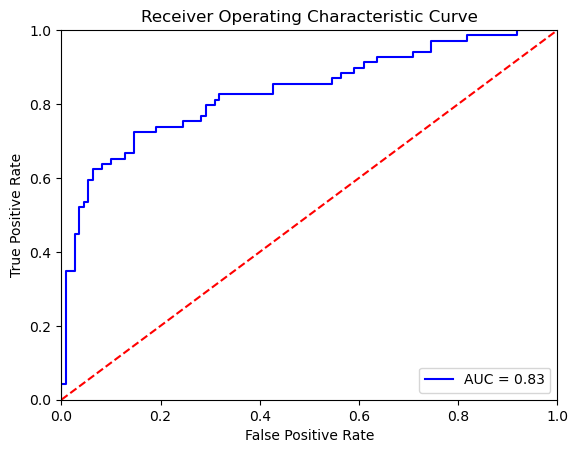

In [17]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
probs = pipe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

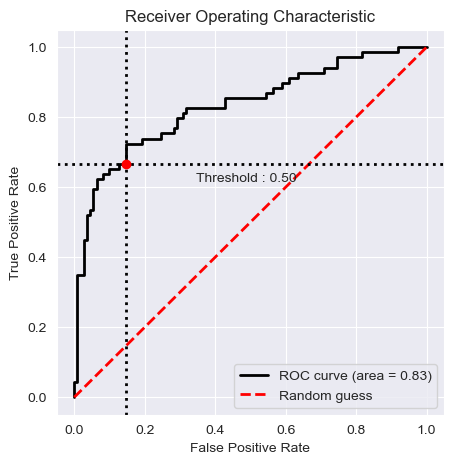

In [18]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
bc = BinaryClassification(y_test, preds, labels=["Class 1", "Class 2"])

plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

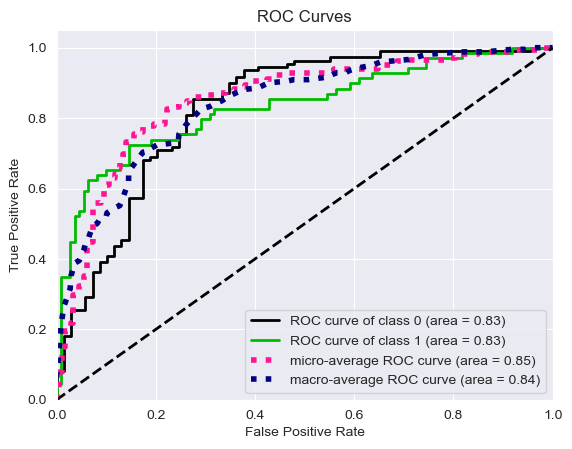

In [19]:
y_true = y_test
predictions = pipe.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_true, predictions)
plt.show()

In [22]:
auc = roc_auc_score(y_test, preds)
print(auc)

0.833201581027668


In [23]:
# https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3
predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.7821229050279329


In [24]:
print(confusion_matrix(y_test, predictions))

[[94 16]
 [23 46]]


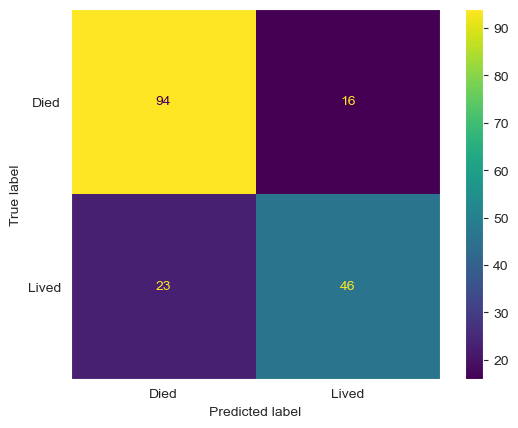

In [25]:
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Died','Lived'])
cmd.plot()
plt.grid(None) # https://stackoverflow.com/questions/53574918/how-to-get-rid-of-white-lines-in-confusion-matrix

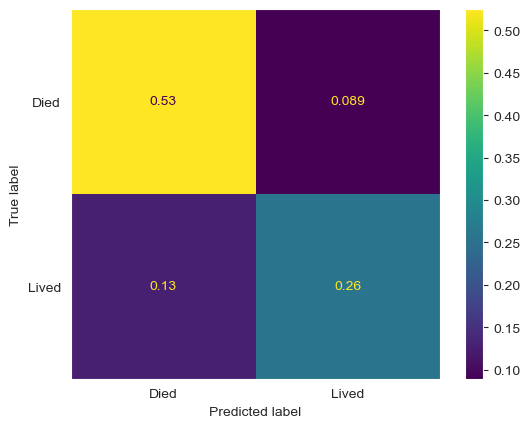

In [26]:
# convert the absolute numbers into percentages of the total
cm = confusion_matrix(y_test, predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Died','Lived'])
cmd.plot()
plt.grid(None)

In [28]:
# undeprecated method
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
print(cm)

[[94 16]
 [23 46]]


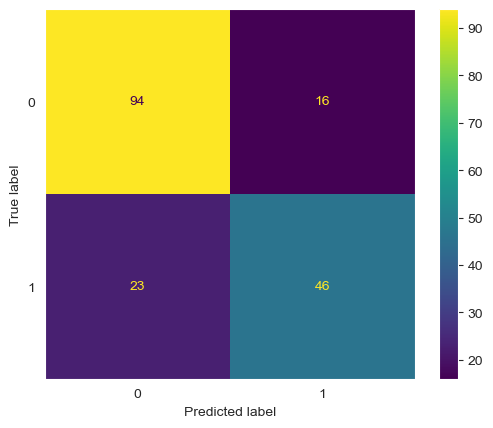

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.grid(None)
pyplot.show()

In [30]:
# the precision score is TP / (TP + FP)
precision_score = precision_score(y_test, predictions)
print(precision_score)

0.7419354838709677


In [31]:
# the recall score is TP / (TP + FN)
recall_score = recall_score(y_test, predictions)
print(recall_score)

0.6666666666666666


In [32]:
f1_score = f1_score(y_test, predictions)
print(f1_score)

0.7022900763358778


A high F1 score indicates the strong overall performance of a binary classification model. It signifies that the model can effectively identify positive cases while minimizing false positives and false negatives.

In [33]:
# Specificity 
# https://stackoverflow.com/questions/33275461/specificity-in-scikit-learn
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn+fp)
print(specificity)

0.8545454545454545


In [34]:
# the negative predictive value
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
NegPredValue = fn / (fn+tn)
print(NegPredValue)

0.19658119658119658
